## Table of Contents

[1. Connecting to Zemo](#1-connecting-to-zemo-through-lan)

[2. NMDA Voltage-Gating Mechanism](#2-nmda-voltage-gating-mechanism)

[3. Inhibitory Synapses: GABA A and GABA B](#3-inhibitory-synapses-gaba_a-and-gaba_b)

# 1. Connecting to Zemo through LAN

For this lab, if you are still having issues connecting to INI VPN, you can use a LAN cable directly.


**Step 1:** From your **local machine** terminal, SSH to Zemo using the username and password sent to you by email:
10.65.48.134 is the Zemo's IP address.

`ssh -X username@10.65.48.134`


**Step 2a:** **On Zemo**, install the correct version of samna:

`pip install samna==0.18.0.0`

also install pandas: `pip install pandas`

**Step 2b:** **On Zemo**, install jupyter 
*If you are using VSCode, you can setup remote developement via the [Remote-SSH extension](https://code.visualstudio.com/docs/remote/ssh) and work with Jupyter notebooks in VSCode.*

**Step 3** **On Zemo**, launch the notebook 

`jupyter notebook --no-browser --port=8866`


**Step 4**: **Back to your loval machine**

`ssh -N -f -L 8866:localhost:8866 username@10.65.48.134`


**Additional useful commands:**

- Map remote directory to local folder: 

`sshfs username@10.65.48.134:/home/username/dir_name local_directory`

- To copy (same PC): `cp -R <source_folder> <destination_folder>`

- To copy (from remote to local):

`scp username@10.65.48.134:/remote_dir_path/Hello_world.ipynb /local_dir_path/folder_name`

- To copy (from local to remote):

`scp local_dir_path/Hello_world.ipynb  username@10.65.134:/remote_dir_path/`

## Import libraries

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import time
import pandas as pd

# Display plots inside Jupyter cell
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90

sys.path.append('/home/class_NI2021/ctxctl_contrib_2023')

In [2]:
import samna
import samna.dynapse1 as dyn1
from dynapse1constants import *
import dynapse1utils as ut
import netgen as n
import params
from bias_names import BIAS_NAMES

In [3]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

### Connecting with the board

A list of the currently available boards to use:

|Board Serial Number|Port to connect to|
| :-- | :-- | 
Device 3 Dynapse1DevKit serial_number 00000001 | sender_port=16344, receiver_port=17245 |
Device 13 Dynapse1DevKit serial_number 00000011 | sender_port=17349, receiver_port=15347 |
Device 12 Dynapse1DevKit serial_number 00000027 | sender_port=12344, receiver_port=12345 |
Device 6 Dynapse1DevKit serial_number 00000020 | sender_port=13923, receiver_port=11992 |
Device 4 Dynapse1DevKit serial_number 00000000 | sender_port=16725, receiver_port=11204 |

Upon calling `open_dynapse1`, you will prompted to select the device by index. Note that the index of a given board can change each time you re-run, so double check on the board serial_number and use its corresponding index.

In [4]:
# open DYNAP-SE1 board to get Dynapse1Model. Use the index specified on the leftmostside to select a device
device_name = 'dynpase_test' # pick any name
model,no_gui = ut.open_dynapse1(gui=False, sender_port=1625, receiver_port=12437, select_device=True) # returns Dynapse1Model

[0]:  Bus 1 Device 3 Dynapse1DevKit serial_number 00000001
[1]:  Bus 1 Device 23 Dynapse1DevKit serial_number 00000007
[2]:  Bus 1 Device 22 Dynapse1DevKit serial_number 00000027
[3]:  Bus 1 Device 27 Dynapse1DevKit serial_number 00000000
[4]:  Bus 1 Device 24 Dynapse1DevKit serial_number 00000020
[5]:  Bus 1 Device 26 Dynapse1DevKit serial_number 00000011
Sender port: tcp://0.0.0.0:1625
Receiver port: tcp://0.0.0.0:12437
Opened device name: Dynapse1DevKit
SamnaNode ID: 1
PythonNode ID: 2


In [5]:
# silent all neurons
paramGroup = params.gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

### Setting the Biases



DPI neuronal parameters
***
| Bias Name | Description |
| :-- | :-- | 
| IF_THR_N | the gain factor of neuron. |
| IF_TAU1_N/IF_TAU2_N | the membrane time-constant of leakage current. |
| IF_RFR_N | refractory period. |
| IF_DC_P | Inject constant current. |

***
Synaptic parameters
***

| Abbreviations | Description |
| :-- | :-- |
|F_P | Fast |
|S_P | Slow |
|II | Inhibitory |
|EE | Excitatory |
    
***
Bias names: `NPDPIE_TAU_F_P,NPDPIE_TAU_S_P,NPDPII_TAU_F_P,NPDPII_TAU_S_P`
    

NPDP[II_or_IE]\_TAU\_[F_or_S]_P : corresponds to **leakage current**, i.e. how much current is constantly leaked away. It represents the time-constant of current decay. 
    
*** 
    
Bias names: `NPDPIE_THR_F_P, NPDPIE_THR_S_P, NPDPII_THR_F_P, NPDPII_THR_S_P`
    

NPDP[II_or_IE]\_THR\_[F_or_S]_P: the gain factor of the synapse. 

*** 
    
Bias names: `PS_WEIGHT_EXC_F_N,PS_WEIGHT_EXC_S_N,PS_WEIGHT_INH_F_N,PS_WEIGHT_INH_S_N` : Weight Bias
*** 
    
Bias name: `IF_NMDA_N`: Sets NMDA gating-threshold

***



There are biases to set adaptation but that is not listed here.

The biases are tuned via two knobs:

    - a coarse value: [0,8)
    - a fine value: [0, 256)
    


<div class="alert alert-block alert-danger">
    
Remark: For projects, json and txt file for parameter would be better, I will send the example files later via email 
</div>

In [7]:
# Some utility functions you can use
def display_model_config(model_config, chip_id, core_id, param_name=None):
    """
    Utility function to print the current configuration for a given chip_id and core_id.
    If param_name is not provided, all the parameters are displayed.
    """
    if param_name is None:  # if not none
        for bias_name in BIAS_NAMES:
            bias_coarse = model_config.chips[chip_id].cores[core_id].parameter_group.param_map[bias_name].coarse_value
            bias_fine = model_config.chips[chip_id].cores[core_id].parameter_group.param_map[bias_name].fine_value
            print(f"{bias_name}  Coarse:{bias_coarse}    Fine:{bias_fine}")
    else:
        bias_coarse = model_config.chips[chip_id].cores[core_id].parameter_group.param_map[param_name].coarse_value
        bias_fine = model_config.chips[chip_id].cores[core_id].parameter_group.param_map[param_name].fine_value
        print(f"{param_name}  Coarse:{bias_coarse}    Fine:{bias_fine}")
    

## 2. NMDA Voltage-Gating Mechanism

In this part, we will try to activate the NMDA voltage-gating mechanism:

**Step#1**: Provide Poisson input (e.g 200 Hz) to a neuron population (e.g 5 neurons) via AMPA synapses. Tune the weight and time constant of the synapse to make the neuron population fire at about 100 Hz without any DC current injection. Remember: AMPA is a `fast` excitatory synapse, adjust the time constant with this information in mind!

**Step#2**: Reset the weight of the AMPA synapse back to 0 (`PS_WEIGHT_EXC_F_N: coarse=0, fine=0`). Connect another input stimulus via an NMDA synapse to the same neuron population above. Make sure that the NMDA voltage threshold is set to its lowest value. 
`IF_NMDA_N: coarse=0, fine=0`. Now tune the weights of the NMDA synapse to make the neuron population fire. Remember: NMDA is a `slow` excitatory synapse!


**Step#3** Re-activate the AMPA synapse by setting the weight back to the value found in Step#1. What is the average population activity now? Did it increase/decrease?

**Step#4**: Slowly increase the NMDA threshold (`IF_NMDA_N: coarse=0, fine=0`). How does this affect the average population activity?

**Step#5**: Repeat Step#4 for different input stimulus frequency and plot the FF curves for the different NMDA thresholds.
------


To tune the NMDA synapse:
- `IF_NMDA_N`: NMDA voltage threshold
- `PS_WEIGHT_EXC_S_N`: weight 
- `NPDPIE_TAU_S_P`: time constant
- `NPDPIE_THR_S_P`: gain

In [75]:
# Create a population of neurons to receive 
net_gen = n.NetworkGenerator()

# Spike Generator for NMDA input + for AMPA input
spike_gens = [10,11]
spgen_chip_id = 0
spgen_core_id = 1

# nids = np.arange(100, 100 + n_mu, 1)

spikegen_nmda = n.NeuronGroup(spgen_chip_id , spgen_core_id, [spike_gens[0]] ,True) 
spikegen_ampa = n.NeuronGroup(spgen_chip_id , spgen_core_id, [spike_gens[1]] ,True) 

# print(f'Spike Gen\n Chip Id: {spikegen.chip_id}, Core Id: {spikegen.core_id},  Ids: {spikegen.neuron_ids},  Object: {spikegen.neurons}')


# Output DPI neuron population representing a singlf DoF
neu_chip_id = 0
neu_core_id = 1
neu_pop = 5

neu_ids = np.arange(14, 14 + neu_pop ,1)
DPI_neuron = n.NeuronGroup(neu_chip_id, neu_core_id, neu_ids)

# Connect all2all with AMPA synpase
syn = n.Synapses(spikegen_nmda, DPI_neuron, dyn1.Dynapse1SynType.NMDA, conn_type='all2all')

n.add_synapses(net_gen, syn)

syn = n.Synapses(spikegen_ampa, DPI_neuron, dyn1.Dynapse1SynType.AMPA, conn_type='all2all')

n.add_synapses(net_gen, syn)

print(net_gen.network)

Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n17: [('C0c1s10', 'NMDA'), ('C0c1s11', 'AMPA')]
C0c1n14: [('C0c1s10', 'NMDA'), ('C0c1s11', 'AMPA')]
C0c1n18: [('C0c1s10', 'NMDA'), ('C0c1s11', 'AMPA')]
C0c1n16: [('C0c1s10', 'NMDA'), ('C0c1s11', 'AMPA')]
C0c1n15: [('C0c1s10', 'NMDA'), ('C0c1s11', 'AMPA')]



In [76]:
# apply configuration
current_config = net_gen.make_dynapse1_configuration()
model.apply_configuration(current_config)

In [77]:
def organize_results(events, df_spikes=None):
    # evts_n = np.array([[evt.timestamp, evt.neuron_id] for evt in events])
    timestamp_offset = 0 
    if df_spikes is None:
        df_spikes = pd.DataFrame()
    for evt in events:
        if timestamp_offset==0:
            timestamp_offset = evt.timestamp
        spikeData = dict(chip = evt.chip_id, 
                        core = evt.core_id,
                        neuron_id = evt.neuron_id,
                        times =(evt.timestamp-timestamp_offset)* 1e-6)
        df_spikes = pd.concat([df_spikes,pd.DataFrame(spikeData,index=[0])])
    return df_spikes

In [259]:
# Set biases for nmda threshold and DC injection
def set_bias_nmda_exp():
    paramGroup = dyn1.Dynapse1ParameterGroup()
    
    #------------------------AMPA parameters----------------------#
    # leakage of AMPA
    paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 5 
    paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 125

    # gain of AMPA
    paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 5
    paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 40

    # weight of AMPA
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 6 
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 30  

    #------------------------NMDA parameters----------------------#
    # first keep NMDA threshold to 0: i.e deactivate (AMPA_like) at coarse 0
    paramGroup.param_map["IF_NMDA_N"].coarse_value = 4 
    paramGroup.param_map["IF_NMDA_N"].fine_value = 255
    #

    # Adjust weight of NMDA
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 5 #0
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 60

    # # NMDA time constant
    paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 7#2
    paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 125
    
    # NMDA gain
    paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 4
    paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 10

    #--------------------Neuron parameters--------------------------#
    # Inject current to make neuron fire
    paramGroup.param_map["IF_DC_P"].coarse_value = 0
    paramGroup.param_map["IF_DC_P"].fine_value = 0

    # Reduce neuron leakage
    paramGroup.param_map["IF_TAU1_N"].coarse_value = 4
    paramGroup.param_map["IF_TAU1_N"].fine_value = 80

    return paramGroup


In [245]:
chip_param = set_bias_nmda_exp()
model.update_parameter_group(chip_param, DPI_neuron.chip_id, DPI_neuron.core_id)

# set the input
poisson_gen = model.get_poisson_gen()

# get global ids of neurons
spikegen_gids_nmda = ut.get_global_id_list(spikegen_nmda.tuple_neuron_ids)  
spikegen_gids_ampa = ut.get_global_id_list(spikegen_ampa.tuple_neuron_ids)  

print(spikegen_gids_nmda,spikegen_gids_ampa )

# Set target chip
post_chip = DPI_neuron.chip_id
poisson_gen.set_chip_id(post_chip)

rate_nmda = 100#20 #in Hz
rate_ampa = 100

poisson_gen.write_poisson_rate_hz(spikegen_gids_nmda[0], rate_nmda)
poisson_gen.write_poisson_rate_hz(spikegen_gids_ampa[0], rate_ampa)

[266] [267]


In [263]:
# tau_nmda = dyn1.Dynapse1Parameter("NPDPIE_TAU_S_P", 2, 125)
# model.update_single_parameter(tau_nmda, DPI_neuron.chip_id, DPI_neuron.core_id)

In [264]:
# Create a graph to monitor output spikes
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, DPI_neuron.tuple_neuron_ids)

# start gens
poisson_gen.start()

# Start graph 
graph.start()

# Clear buffer
sink_node.get_events()

for i in range(3):
    # get spikes every 2 seconds
    time.sleep(4)
    events = sink_node.get_events()
    # process the events
    print(len(events),"events.")

graph.stop()
poisson_gen.stop()

# Organize events
results_df = organize_results(events)

199 events.
197 events.
211 events.


In [266]:
ut.save_parameters2txt_file(model.get_configuration(), 'nmda_ampa_volt_gating.txt')

Text(0.5, 1.0, 'Output spikes')

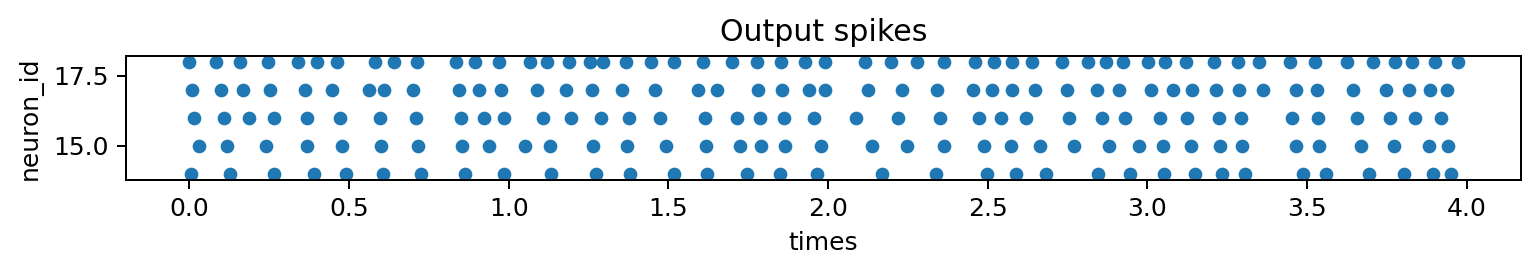

In [267]:
# plot input spikes 
fig = plt.figure(figsize=(10,2))

ax = fig.add_subplot(2,1,1)
results_df.plot(x='times', y='neuron_id',kind='scatter', ax=ax)
plt.title("Output spikes")

## 3. Inhibitory Synapses: GABA_A and  GABA_B
  

In [33]:
# --------------- GABA_B inhibition ----------------
# first reuse part1 to make the neuron fire at 100Hz
# with proper parameters, then add 1 GABA_B synapse 
# between a Poissongen and this neuron. Use different
# input rate to inhibit the neuron and monitor its output rates.


# set initial (proper) parameters
paramGroup = params.gen_clean_param_group()
for neu_chip_id in range(4):
    for neu_core_id in range(4):
        model.update_parameter_group(paramGroup, neu_chip_id, neu_core_id)

# select a spike generator
schip = 0
score = 0
sid = 1

# choose a neuron to monitor.
neu_chip_id = 0
neu_core_id = 1
neu_ids = 16

# inh weights
w_coarse_values = np.arange(0, 8, 1)#7
w_fine_value = 180#np.arange(0, 9, 3)

# input rates
input_freqs = np.arange(20, 200, 20)

duration = 1

# result frequency list
output_rates = np.zeros((len(w_coarse_values), len(input_freqs)))

# get the global neuron ID of the neuron
monitored_global_nid = ut.get_global_id(neu_chip_id, neu_core_id, neu_ids)

####################### TODO #######################
# tune parameters, you may change the params below 
# and feel free to play with more options
# set DC of this core
param = dyn1.Dynapse1Parameter("IF_DC_P", 4, 200)
model.update_single_parameter(param, neu_chip_id, neu_core_id)
# decrease the leak
param = dyn1.Dynapse1Parameter("IF_TAU1_N", 3, 40)
model.update_single_parameter(param, neu_chip_id, neu_core_id)
####################### TODO #######################


####################### TODO #######################
# build network
# init a network generator
net_gen = n.NetworkGenerator()
spikegen = n.Neuron(schip, score, sid, True)
neuron = n.Neuron(neu_chip_id, neu_core_id, neu_ids)

# connect spikegen to neuron (only in the network topology not chips for now)
net_gen.add_connection(spikegen, neuron, dyn1.Dynapse1SynType.GABA_B)

# print the network so you can double check (optional)
net_gen.print_network()
# make a dynapse1config using the network
new_config = net_gen.make_dynapse1_configuration()
# apply the configuration
model.apply_configuration(new_config)
####################### TODO #######################


# get fpga_spike_gen
fpga_spike_gen = model.get_fpga_spike_gen()


####################### TODO #######################
# create a graph to monitor the spikes of this neuron
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, [(neu_chip_id, neu_core_id, neu_ids)])
####################### TODO #######################

for i in range(len(w_coarse_values)):
    # set weight of GABA_B
    param = dyn1.Dynapse1Parameter("PS_WEIGHT_INH_S_N", w_coarse_values[i], w_fine_value)
    model.update_single_parameter(param, neu_chip_id, neu_core_id)

    for j in range(len(input_freqs)):
        # set up FPGA spike gens
        # preload the stimulus
        spikegen_global_id = ut.get_global_id(schip, score, sid)
        sample_duration = 4
        # generate spike times
        spike_count = input_freqs[j] * sample_duration 
        spike_times = np.linspace(0, sample_duration, spike_count)
        print(spike_count, len(spike_times))
        # generate spikegen id list corresponding to spike_times
        indices = [spikegen_global_id]*len(spike_times)

        # the chips where the post neurons are
        target_chips = [neu_chip_id]*len(indices)
        isi_base = 900
        repeat_mode=False

        # set up the fpga_spike_gen
        ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, indices, target_chips, isi_base, repeat_mode)

        graph.start()
        fpga_spike_gen.start()

        ####################### TODO #######################
        # get events
        # clear the output buffer
        sink_node.get_events()
        # sleep for 1 sec
        time.sleep(duration)
        # get the events accumulated during the past 1 sec
        events = sink_node.get_events()
        ####################### TODO #######################

        fpga_spike_gen.stop()
        graph.stop()

        # Accumulate the results
        print(len(events))
        freq = len(events)/duration
        output_rates[i][j] = freq

print(output_rates)



Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n16: [('C0c0s1', 'GABA_B')]

80 80
75
160 160
74
240 240
73
320 320
73
400 400
74
480 480
73
560 560
73
640 640
73
720 720
73
80 80
74
160 160
74
240 240
74
320 320
74
400 400
74
480 480
73
560 560
74
640 640
73
720 720
74
80 80
74
160 160
73
240 240
74
320 320
74
400 400
74
480 480
74
560 560
74
640 640
74
720 720
73
80 80
74
160 160
74
240 240
73
320 320
73
400 400
74
480 480
73
560 560
73
640 640
73
720 720
73
80 80
74
160 160
73
240 240
74
320 320
73
400 400
74
480 480
74
560 560
73
640 640
73
720 720
73
80 80
74
160 160
73
240 240
73
320 320
73
400 400
73
480 480
73
560 560
74
640 640
74
720 720
73
80 80
73
160 160
72
240 240
72
320 320
71
400 400
71
480 480
71
560 560
70
640 640
71
720 720
69
80 80
59
160 160
41
240 240
60
320 320
1
400 400
1
480 480
1
560 560
0
640 640
0
720 720
1
[[75. 74. 73. 73. 74. 73. 73. 73. 73.]
 [74. 74. 74. 74. 74. 73. 74. 73. 74.]
 [74. 73. 74. 74. 74. 74. 74.

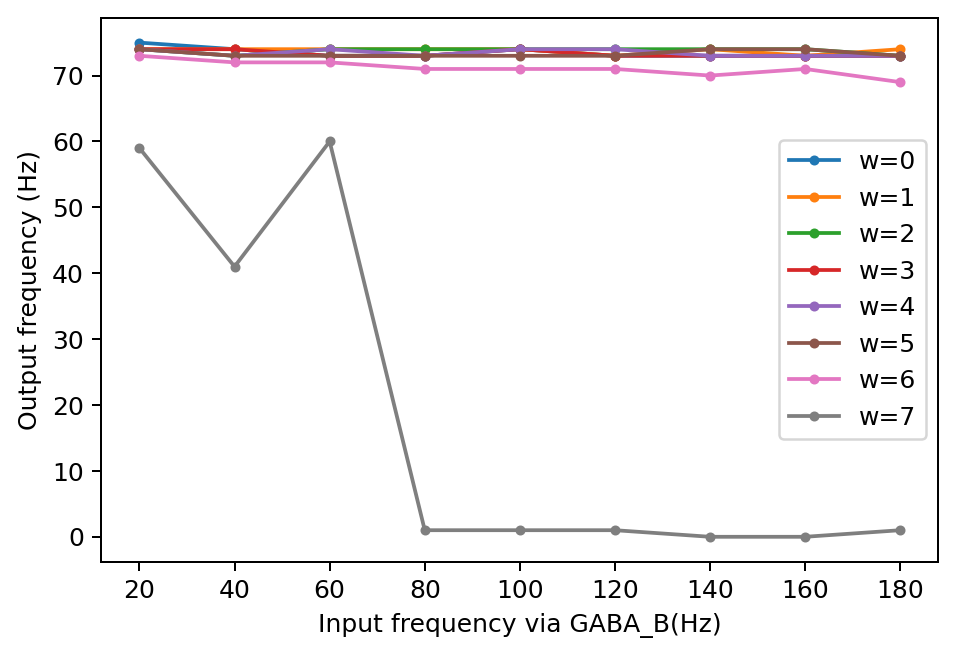

In [34]:
# inh weights
w_coarse_values = np.arange(0, 8, 1)#7

w_fine_values = 180#np.arange(0, 9, 3)

# input rates
input_freqs = np.arange(20, 200, 20)


fig = plt.figure()
for i in range(len(w_coarse_values)):
    out_rates = output_rates[i]
    plt.plot(input_freqs, out_rates, ".-", label = "w="+str(w_coarse_values[i]))
plt.xlabel('Input frequency via GABA_B(Hz)')
plt.ylabel('Output frequency (Hz)')
plt.legend()
plt.show()

In [ ]:
config1 = model.get_configuration()

print("Coarse: " + str(config1.chips[0].cores[1].parameter_group.param_map['IF_DC_P'].coarse_value))
print("Fine: " + str(config1.chips[0].cores[1].parameter_group.param_map['IF_DC_P'].fine_value))

In [12]:
current_config = model.get_configuration()
display_model_config(current_config, 0, 1)

IF_AHTAU_N  Coarse:4    Fine:80
IF_AHTHR_N  Coarse:4    Fine:80
IF_AHW_P  Coarse:0    Fine:0
IF_BUF_P  Coarse:4    Fine:80
IF_CASC_N  Coarse:0    Fine:0
IF_DC_P  Coarse:6    Fine:30
IF_NMDA_N  Coarse:0    Fine:0
IF_RFR_N  Coarse:4    Fine:3
IF_TAU1_N  Coarse:0    Fine:5
IF_TAU2_N  Coarse:0    Fine:100
IF_THR_N  Coarse:3    Fine:120
NPDPIE_TAU_F_P  Coarse:0    Fine:40
NPDPIE_TAU_S_P  Coarse:0    Fine:0
NPDPIE_THR_F_P  Coarse:0    Fine:0
NPDPIE_THR_S_P  Coarse:0    Fine:40
NPDPII_TAU_F_P  Coarse:0    Fine:0
NPDPII_TAU_S_P  Coarse:0    Fine:40
NPDPII_THR_F_P  Coarse:0    Fine:0
NPDPII_THR_S_P  Coarse:0    Fine:0
PS_WEIGHT_EXC_F_N  Coarse:0    Fine:0
PS_WEIGHT_EXC_S_N  Coarse:0    Fine:0
PS_WEIGHT_INH_F_N  Coarse:0    Fine:0
PS_WEIGHT_INH_S_N  Coarse:7    Fine:180
PULSE_PWLK_P  Coarse:4    Fine:106
R2R_P  Coarse:3    Fine:85


## Inhibitory Synapses: GABA A & GABA B

In this part, we will see the effect of the two types of inhibitory synapses on the neuron:

**Step#1**: Inject a DC current into a small population of neurons (e.g 5 neurons) and adjust the neuron time constant to make it fire at about 100 Hz.

**Step#2**: Connect a GABA_B synapse to the above neuron population through an FPGA spike generator.

**Step#3**: For a given synaptic weight, sweep over the frequency of the provided input, compute the average firing rate of the neuron population.

**Step#4**: Change the synaptic weight. Plot the average population response to the change in input frequency and synaptic weight (i.e create a FF trace for each synaptic weight).


**Step#5**: Repeat the same steps 1-4 using a GABA_A synapse.

---

**Question**: What do you observe from these two plots? Can you say something about the different inhibitory effect of those synapses?

### GABA-B (Shunting)

To tune GABA-B, you should tune parameters of the slow inhibitory synapse:
- `PS_WEIGHT_INH_S_N`: for the weight
- `NPDPII_THR_S_P`: for the gain
- `NPDPII_TAU_S_P`: for the time constant

In [47]:
# set initial (proper) parameters
paramGroup = params.gen_clean_param_group()
for neu_chip_id in range(4):
    for neu_core_id in range(4):
        model.update_parameter_group(paramGroup, neu_chip_id, neu_core_id)


# select a spike generator
schip = 0
score = 0
sid = [1]

# select neuron population
neu_chip_id = 0
neu_core_id = 1
nid = [18,19, 20]


# set range of inpute rates
input_freqs = np.arange(20, 300, 50)
duration = 1


####################### TODO #######################
# tune parameters
# inh weights: sweep over coarse value
w_coarse_values = np.arange(8)  
w_fine_value = 180 

# result frequency list
output_rates = np.zeros((len(w_coarse_values), len(input_freqs)))

# set DC for this core
param = dyn1.Dynapse1Parameter("IF_DC_P", 4, 200)
model.update_single_parameter(param, neu_chip_id, neu_core_id)

# decrease neuron's leak
param = dyn1.Dynapse1Parameter("IF_TAU1_N", 3, 40)
model.update_single_parameter(param, neu_chip_id, neu_core_id)

# you can also tune the gain of the synapse
# param = dyn1.Dynapse1Parameter("NPDPII_THR_S_P", 3, 40)
# model.update_single_parameter(param, neu_chip_id, neu_core_id)

####################### TODO #################################


####################### Build Network #######################
# init a network generator
net_gen = n.NetworkGenerator()
spikegen = n.NeuronGroup(schip, score, sid, True)
neuron = n.NeuronGroup(neu_chip_id, neu_core_id, nid)

# connect spikegen to neuron
syn = n.Synapses(spikegen, neuron, dyn1.Dynapse1SynType.GABA_B, conn_type='all2all')
n.add_synapses(net_gen, syn)

# print the network so you can double check (optional)
print(net_gen.network)

# make a dynapse1config using the network and apply it
new_config = net_gen.make_dynapse1_configuration()
model.apply_configuration(new_config)

print(f"Network Build!")

####################### Get FPGA SpikeGen #######################

# get fpga_spike_gen
fpga_spike_gen = model.get_fpga_spike_gen()


####################### Set Graph #######################
# create a graph to monitor the spikes of this neuron
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, neuron.tuple_neuron_ids)

####################### Loop over weights and input frequency #######################
for i in range(len(w_coarse_values)):
    # set weight of GABA_B
    param = dyn1.Dynapse1Parameter("PS_WEIGHT_INH_S_N", w_coarse_values[i], w_fine_value)
    model.update_single_parameter(param, neu_chip_id, neu_core_id)

    for j in range(len(input_freqs)):
        # -------- Prepare stimulus --------
        # preload the stimulus
        sample_duration = 4

        # 1. Generate spike times
        spike_count = input_freqs[j] * sample_duration 
        spike_times = np.linspace(0, sample_duration, spike_count)

        # 2. Get global ids of neurons
        spikegen_gids = ut.get_global_id_list(spikegen.tuple_neuron_ids)  

        # 3. Generate spikegen id list corresponding to spike_times
        indices = [spikegen_gids]*len(spike_times)

        # 4. Set the chips where the post neurons are
        target_chips = [neu_chip_id]*len(indices)
        isi_base = 900
        repeat_mode=False

        # set up the fpga_spike_gen
        ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, indices, target_chips, isi_base, repeat_mode)

        graph.start()
        fpga_spike_gen.start()

        ####################### TODO #######################
        # get events
        # Clear buffer
        sink_node.get_events()
        # sleep for 1 sec
        time.sleep(duration)
        # get the events accumulated during the past 1 sec
        events = sink_node.get_events()
        ####################### TODO #######################

        fpga_spike_gen.stop()
        graph.stop()

        # append the frequency to the list
        pop_mean_rate = len(events)/duration/len(nid)
        output_rates[i][j] = pop_mean_rate
        print(f"in:{input_freqs[j]}   w_coarse:{w_coarse_values[i]}  fine:{w_fine_value}  Events Count:{pop_mean_rate}")


Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n19: [('C0c0s1', 'GABA_B')]
C0c1n18: [('C0c0s1', 'GABA_B')]
C0c1n20: [('C0c0s1', 'GABA_B')]

Network Build!
in:20   w_coarse:0  fine:180  Events Count:83.66666666666667
in:70   w_coarse:0  fine:180  Events Count:84.0
in:120   w_coarse:0  fine:180  Events Count:83.66666666666667
in:170   w_coarse:0  fine:180  Events Count:83.66666666666667
in:220   w_coarse:0  fine:180  Events Count:83.33333333333333
in:270   w_coarse:0  fine:180  Events Count:83.66666666666667
in:20   w_coarse:1  fine:180  Events Count:84.0
in:70   w_coarse:1  fine:180  Events Count:83.33333333333333
in:120   w_coarse:1  fine:180  Events Count:83.33333333333333
in:170   w_coarse:1  fine:180  Events Count:84.0
in:220   w_coarse:1  fine:180  Events Count:83.66666666666667
in:270   w_coarse:1  fine:180  Events Count:83.66666666666667
in:20   w_coarse:2  fine:180  Events Count:83.66666666666667
in:70   w_coarse:2  fine:180  Events

In [48]:
output_rates.shape, input_freqs.shape, w_fine_value, w_coarse_values
# Prepare the data in df

gaba_a_df = pd.DataFrame(output_rates.T,columns=w_coarse_values)
# gaba_a_df.index = input_freqs
gaba_a_df

,0,1,2,3,4,5,6,7
0,83.666667,84.000000,83.666667,83.666667,84.000000,82.000000,79.333333,79.000000
1,84.000000,83.333333,84.000000,84.000000,83.333333,78.333333,69.000000,70.000000
2,83.666667,83.333333,84.000000,84.000000,83.333333,74.333333,0.000000,0.000000
3,83.666667,84.000000,83.333333,83.666667,84.000000,69.666667,0.333333,0.666667
4,83.333333,83.666667,83.333333,83.333333,84.000000,66.333333,0.000000,0.666667
5,83.666667,83.666667,83.666667,84.000000,83.666667,60.333333,1.000000,0.666667


In [49]:
output_rates

array([[83.66666667, 84.        , 83.66666667, 83.66666667, 83.33333333,
        83.66666667],
       [84.        , 83.33333333, 83.33333333, 84.        , 83.66666667,
        83.66666667],
       [83.66666667, 84.        , 84.        , 83.33333333, 83.33333333,
        83.66666667],
       [83.66666667, 84.        , 84.        , 83.66666667, 83.33333333,
        84.        ],
       [84.        , 83.33333333, 83.33333333, 84.        , 84.        ,
        83.66666667],
       [82.        , 78.33333333, 74.33333333, 69.66666667, 66.33333333,
        60.33333333],
       [79.33333333, 69.        ,  0.        ,  0.33333333,  0.        ,
         1.        ],
       [79.        , 70.        ,  0.        ,  0.66666667,  0.66666667,
         0.66666667]])

Text(0.5, 1.0, 'GABA A')

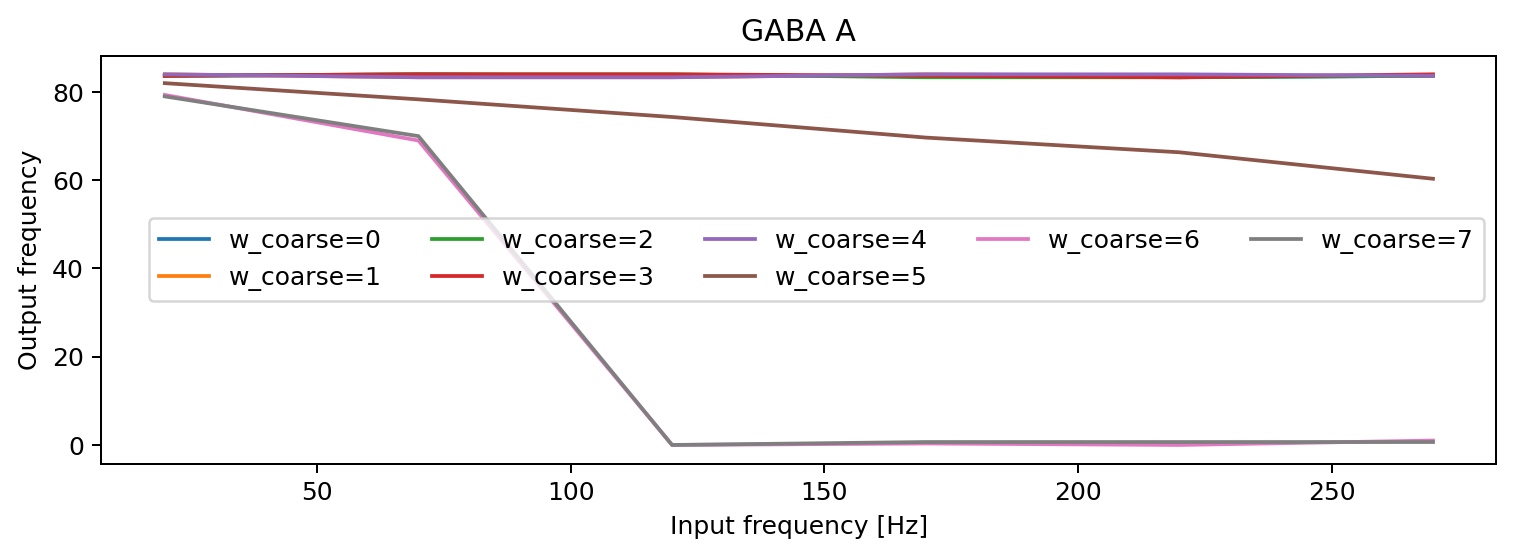

In [50]:
fig  = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1)

for i in range(len(w_coarse_values)):

    ax.plot(input_freqs, output_rates[i], label= f"w_coarse={w_coarse_values[i]}")
plt.legend(ncol=5)
plt.xlabel('Input frequency [Hz]')
plt.ylabel('Output frequency')
plt.title("GABA A")

### GABA-A

Repeat the same procedure for GABA-A.
To tune this synapse, change the parameters of the fast inhibitory synapse.

- `PS_WEIGHT_INH_F_N`: for the weight
- `NPDPII_THR_F_P`: for the gain
- `NPDPII_TAU_F_P`: for the time constant

In [ ]:
# # close Dynapse1
# ut.close_dynapse1(store, device_name)